In [31]:
%cd /om2/vast/cbmm/xboix/src/Robustness

/om2/vast/cbmm/xboix/src/Robustness


In [32]:
experiment_name = "uci_all"
results_dir = '/vast/robustness/' + experiment_name + '/'

In [3]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.set_context("poster")

import matplotlib.pyplot as plt
import pandas as pd
import pickle 
import os 

import numpy as np
import pandas
    
import runs.config_experiments_uci_all as run
experiment_list = run.config_experiments(results_dir, create_json=False)

36064 config files created


In [4]:
if not os.path.isfile('/vast/robustness/datasets/UCI/datasets_info.csv'):
    import json
    datasets = []
    for data_set in range(20,66):
        with open('/vast/robustness/configs_datasets/' + str(data_set) + '.json') as config_file:
            config = json.load(config_file)
            tmpX = np.shape(np.genfromtxt('/vast/robustness/datasets/UCI/imp_' + config["name_file"] 
                                 + '_' + "trainX.csv", delimiter=','))
            config["num_examples"] = tmpX[0]
            config["num_features"] = tmpX[1]
            datasets.append(config)
    df = pd.DataFrame(datasets) 
    df.to_csv('/vast/robustness/datasets/UCI/datasets_info.csv')
else:
    df = pd.read_csv('/vast/robustness/datasets/UCI/datasets_info.csv')

name_attacks = ["l1_pgd_norm", "l1_fgm_norm","l2_pgd_norm", "l2_fgm_norm", "linf_pgd","l2_pgd", "linf_fgsm", "l2_fgm"]#


In [5]:
df[(df.num_features>50) & (df.num_examples > 500)]

,Unnamed: 0,dataset_id,dataset_name,name_file,num_classes,num_examples,num_features
0,0,20,UCI,ozone-level-detection-eight,2,2027,73
4,4,24,UCI,optical-recognition-handwritten-digits,10,3058,65
15,15,35,UCI,spambase,2,3681,58
16,16,36,UCI,ozone-level-detection-one,2,2029,73
41,41,61,UCI,cnae-9,9,864,857


In [15]:
df.to_csv('dataset.csv',index=False)

In [23]:
approxs = ['linf', 'l1'] 
test = {}
for approx in approxs:
    file_name = results_dir + experiment_list[1]['model_name'] + '/results/acc_' + 'test' + '_approx_bound_' + approx + '.pkl'
    if not os.path.isfile(file_name):
        print("Missing!! " + file_name)
        continue

    with open(file_name, 'rb') as f:
        tmp = pickle.load(f)
            
    test[approx] = {}
    for epsilon in tmp['bound'].keys():
        test[approx][epsilon] = {}
        test[approx][epsilon]['test'] = 0
        test[approx][epsilon]['total'] = 0
        
for idx, _ in enumerate(experiment_list):
    for approx in approxs:
        file_name = results_dir + experiment_list[idx]['model_name'] + '/results/acc_' + 'test' + '_approx_bound_' + approx + '.pkl'
        if not os.path.isfile(file_name):
            print("Missing!! " + file_name)
            continue

        with open(file_name, 'rb') as f:
            tmp = pickle.load(f)
            
        for epsilon in tmp['bound'].keys():
            if np.isnan(tmp['bound'][epsilon]) or np.isnan(tmp['xent'][epsilon]):
                continue
            test[approx][epsilon]['total'] += 1
            if tmp['bound'][epsilon] >= tmp['xent'][epsilon]:
                test[approx][epsilon]['test'] += 1
for approx in approxs:
    for epsilon in tmp['bound'].keys():
        test[approx][epsilon] = test[approx][epsilon]['test'] /  test[approx][epsilon]['total']     

In [30]:
df_approx = pd.DataFrame.from_dict(test, orient='index')
df_approx.to_csv('bound_approx.csv', index=False)
print(df_approx)

        0.0000    0.0002    0.0005    0.0008    0.0010    0.0015    0.0020  \
linf  0.935609  0.986844  0.987781  0.987490  0.988072  0.987846  0.986941   
l1    0.934030  0.989749  0.990493  0.990816  0.990945  0.990978  0.991042   

        0.0030    0.0100    0.1000    0.3000    0.5000    1.0000  
linf  0.987296  0.984322  0.948991  0.862199  0.803142  0.786527  
l1    0.991366  0.991818  0.990816  0.989458  0.987162  0.981891  


In [19]:

list_entries = []
for net in ['OneLayer', 'ThreeLayer']:
    for dataset_id in list(df.dataset_id): #list(df[(df.num_features>50) & (df.num_examples > 500)].dataset_id):

        for idx, exp in enumerate(experiment_list):
            if exp['data_set'] == dataset_id: 
                break
                
        for attack in name_attacks:

            file_name = results_dir + experiment_list[idx]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
            if not os.path.isfile(file_name):
                print("Missing!! " + file_name)
                continue
            with open(file_name, 'rb') as f:
                tmp = pickle.load(f)


            for cv_epsilon in list(tmp.keys()):
                # Hash table of parameters
                parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
                              "robust_training": {}, "type_robust": {}, "epsilon_pgd_training":{}}

                to_exclude = []
                experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
                for exp in experiment_list_tmp:
                    if not exp['data_set'] == dataset_id: 
                        continue
                    for kk in parameters.keys():
                        if exp[kk] in parameters[kk]:
                            parameters[kk][exp[kk]].append(int(exp["model_name"]))
                        else:
                            parameters[kk][exp[kk]] = [int(exp["model_name"])]


                # For all methods, do cross-val and create an entry of the results
                backbones = [net, net + '+pgd']



                for backbone in backbones:
                    for robust_training in [True, False]:
                        if robust_training:
                            type_robust_trainings = ['l1','linf', "certificate", "grad"] 
                        else:
                            type_robust_trainings = ['none']
                        for type_robust in type_robust_trainings:

                            if (backbone == 'Madry' and robust_training == True) or \
                                (backbone == 'CNN+clipping' and robust_training == False):
                                continue

                            if robust_training==False:
                                ids = list(set(parameters["backbone"][backbone]) & 
                                           set(parameters["robust_training"][False]))
                            else:
                                ids = list(set(parameters["backbone"][backbone]) & 
                                       set(parameters["robust_training"][True])&
                                      set(parameters["type_robust"][type_robust]))



                            if backbone == net + '+pgd' and robust_training == True:
                                continue

                            if ids == []:
                                continue
                            #print(ids)


                            # Cross-validation among learning rates and epsilons:
                            best_acc = -1
                            best_id = ids[0]
                            for id in ids:
                                file_name = results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + attack + '.pkl'
                                if not os.path.isfile(file_name):
                                    print("Missing!! " + file_name)
                                    continue

                                with open(file_name, 'rb') as f:
                                    tmp = pickle.load(f)

                                acc = tmp[cv_epsilon]
                                if acc>best_acc:
                                    best_id = id
                                    best_acc = acc

                            if best_acc == -1:
                                continue

                            if (robust_training == False) & (backbone==net):  
                                name_legend = 'vanilla'
                            elif backbone== net + '+pgd':
                                name_legend = 'pgd'
                            else:
                                if type_robust=='certificate':
                                    name_legend = 'RUB'
                                elif type_robust=='linf':
                                    name_legend = 'aRUB_Linf'
                                elif type_robust=='grad':
                                    name_legend = 'grad'
                                else:
                                    name_legend = 'aRUB_L1'

                            entry = {"dataset": dataset_id,
                                     "net": net,
                                    "learning_rate": experiment_list[best_id]['initial_learning_rate'],
                                    #"backbone": net, #experiment_list[best_id]['backbone'],
                                    "robust_training": name_legend,
                                    "epsilon": experiment_list[best_id]['epsilon'],
                                    "epsilon_pgd_training": experiment_list[best_id]['epsilon_pgd_training']}

                            dataset = "test"
                            entry["attack"] = attack
                            entry["experiment_id"] = best_id

                            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                                attack + '.pkl', 'rb') as f:
                                tmp = pickle.load(f)

                            entry["test_epsilon"] = cv_epsilon
                            entry["accuracy"] =  100*tmp[cv_epsilon]
                            
                            with open(results_dir + experiment_list[best_id]['model_name'] + 
                                          '/results/training_time.pkl', 'rb') as f:
                                tmp = pickle.load(f)
                                entry["images_per_second"] = np.mean(tmp) 
                                entry["std_images_per_second"] = np.std(tmp) 

                            #with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + 'test' + '_' + 
                            #        'bound' + '.pkl', 'rb') as f:
                            #    tmp = pickle.load(f)
                            #if type_robust == 'certificate':
                            #    print(tmp)
                            #entry["bound"] =  100*tmp[cv_epsilon]
                            
                            list_entries.append(entry.copy())

df_results = pd.DataFrame.from_dict(list_entries) 


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
df_results.to_csv('uci_norm.csv', index=False)

In [25]:
for dataset_id in list(df[(df.num_features>50) & (df.num_examples > 500)].dataset_id):
    print(dataset_id)
    print("-----------------------------------------")
    
    for net in ['OneLayer', 'ThreeLayer']:

        ss = df_results[(df_results.net == net) & (df_results.dataset == dataset_id) & (df_results.attack == 'l1_pgd_norm')].pivot(index=['robust_training'], columns=['test_epsilon'], values=['accuracy'])
        display(ss)

20
-----------------------------------------


accuracy                                                  \
test_epsilon       0.000000    0.001709    0.004272    0.006835    0.008544   
robust_training                                                               
RUB               99.609375   99.609375   99.609375   99.609375   99.609375   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad              99.804688   99.804688   99.804688   99.804688   99.804688   
pgd               99.609375   99.609375   99.609375   99.609375   99.609375   
vanilla           99.609375   99.609375   99.609375   99.609375   99.609375   

                                                                             \
test_epsilon       0.012816    0.017088    0.025632    0.085440    0.854400   
robust_training                                                               
RUB               99.609375   99.609375   99.609375   99.609375   99.609375   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad              99.804688   99.804688   99.804688   99.804688   99.804688   
pgd               99.609375   99.609375   99.609375   99.609375  100.000000   
vanilla          100.000000  100.000000  100.000000  100.000000  100.000000   

                                                     
test_epsilon       2.563201    4.272002    8.544004  
robust_training                                      
RUB               99.609375   99.609375   99.687500  
aRUB_L1           99.804688   99.648438   92.851562  
aRUB_Linf         99.804688   99.609375   93.203125  
grad              99.609375   99.609375   98.828125  
pgd              100.000000  100.000000  100.000000  
vanilla           99.804688   99.609375   97.226562

accuracy                                                  \
test_epsilon       0.000000    0.001709    0.004272    0.006835    0.008544   
robust_training                                                               
RUB              100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad              99.804688   99.804688   99.804688   99.804688   99.804688   
pgd              100.000000  100.000000  100.000000  100.000000  100.000000   
vanilla          100.000000  100.000000  100.000000  100.000000  100.000000   

                                                                             \
test_epsilon       0.012816    0.017088    0.025632    0.085440    0.854400   
robust_training                                                               
RUB              100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad              99.804688   99.804688   99.804688   99.804688   99.804688   
pgd              100.000000  100.000000  100.000000  100.000000  100.000000   
vanilla          100.000000  100.000000  100.000000  100.000000  100.000000   

                                                    
test_epsilon       2.563201    4.272002   8.544004  
robust_training                                     
RUB              100.000000   99.804688  99.882812  
aRUB_L1           99.765625  100.000000  94.687500  
aRUB_Linf        100.000000  100.000000  94.648438  
grad              99.609375  100.000000  94.687500  
pgd               99.804688  100.000000  94.648438  
vanilla          100.000000  100.000000  94.648438

24
-----------------------------------------


accuracy                                              \
test_epsilon      0.000000   0.001612   0.004031   0.006450   0.008062   
robust_training                                                          
RUB              98.437500  98.437500  98.437500  98.437500  98.437500   
aRUB_L1          98.906250  98.906250  98.906250  98.906250  98.906250   
aRUB_Linf        99.531250  99.531250  99.531250  99.531250  99.531250   
grad             98.906250  98.906250  98.906250  98.906250  98.906250   
pgd              99.257812  99.257812  99.257812  99.257812  99.257812   
vanilla          98.632812  98.632812  98.632812  98.632812  98.632812   

                                                                        \
test_epsilon      0.012093   0.016125   0.024187   0.080623   0.806226   
robust_training                                                          
RUB              98.437500  98.437500  98.437500  98.710938  98.750000   
aRUB_L1          98.906250  98.906250  98.906250  98.867188  98.671875   
aRUB_Linf        99.531250  99.531250  99.531250  99.648438  99.140625   
grad             98.906250  98.906250  98.906250  98.906250  97.968750   
pgd              99.257812  99.257812  99.257812  99.257812  99.453125   
vanilla          98.632812  98.632812  98.632812  98.515625  98.164062   

                                                  
test_epsilon      2.418677   4.031129   8.062258  
robust_training                                   
RUB              98.710938  98.945312  98.710938  
aRUB_L1          97.187500  95.703125  87.539062  
aRUB_Linf        97.578125  95.742188  86.445312  
grad             98.906250  98.164062  98.437500  
pgd              97.617188  97.500000  97.382812  
vanilla          98.125000  98.085938  98.007812

accuracy                                              \
test_epsilon      0.000000   0.001612   0.004031   0.006450   0.008062   
robust_training                                                          
RUB              99.140625  99.140625  99.140625  99.140625  99.140625   
aRUB_L1          98.710938  98.710938  98.710938  98.710938  98.710938   
aRUB_Linf        99.531250  99.531250  99.531250  99.531250  99.531250   
grad             98.984375  98.984375  98.984375  98.984375  98.984375   
pgd              99.531250  99.531250  99.531250  99.531250  99.531250   
vanilla          98.242188  98.242188  98.242188  98.242188  98.242188   

                                                                        \
test_epsilon      0.012093   0.016125   0.024187   0.080623   0.806226   
robust_training                                                          
RUB              99.140625  99.140625  99.140625  99.023438  98.242188   
aRUB_L1          98.710938  98.710938  98.710938  98.710938  97.578125   
aRUB_Linf        99.531250  99.531250  99.531250  99.531250  99.375000   
grad             98.984375  98.984375  98.984375  98.867188  98.007812   
pgd              99.531250  99.531250  99.531250  99.531250  98.828125   
vanilla          98.242188  98.242188  98.242188  98.242188  97.773438   

                                                  
test_epsilon      2.418677   4.031129   8.062258  
robust_training                                   
RUB              98.320312  98.125000  97.929688  
aRUB_L1          96.914062  95.703125  85.937500  
aRUB_Linf        97.578125  94.648438  83.359375  
grad             96.015625  94.023438  85.976562  
pgd              97.929688  96.640625  90.937500  
vanilla          96.015625  93.984375  77.460938

35
-----------------------------------------


accuracy                                                  \
test_epsilon       0.000000    0.001523    0.003808    0.006093    0.007616   
robust_training                                                               
RUB               99.882812   99.882812   99.882812   99.882812   99.882812   
aRUB_L1           99.882812   99.882812   99.882812   99.882812   99.882812   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad              99.882812   99.882812   99.882812   99.882812   99.882812   
pgd              100.000000  100.000000  100.000000  100.000000  100.000000   
vanilla           99.882812   99.882812   99.882812   99.882812   99.882812   

                                                                             \
test_epsilon       0.011424    0.015232    0.022847    0.076158    0.761577   
robust_training                                                               
RUB               99.882812   99.882812   99.882812   99.882812   99.804688   
aRUB_L1           99.882812   99.882812   99.882812   99.882812   99.804688   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad              99.882812   99.882812   99.882812   99.882812   99.804688   
pgd              100.000000  100.000000  100.000000  100.000000  100.000000   
vanilla           99.882812   99.882812   99.882812   99.882812   99.804688   

                                                   
test_epsilon       2.284732   3.807887   7.615773  
robust_training                                    
RUB               99.921875  99.921875  99.843750  
aRUB_L1           99.804688  96.953125  78.242188  
aRUB_Linf         99.804688  99.414062  97.304688  
grad              99.726562  99.882812  99.570312  
pgd              100.000000  99.960938  99.960938  
vanilla           99.765625  98.710938  98.476562

accuracy                                               \
test_epsilon    0.000000 0.001523 0.003808 0.006093 0.007616 0.011424   
robust_training                                                         
RUB                100.0    100.0    100.0    100.0    100.0    100.0   
aRUB_L1            100.0    100.0    100.0    100.0    100.0    100.0   
aRUB_Linf          100.0    100.0    100.0    100.0    100.0    100.0   
grad               100.0    100.0    100.0    100.0    100.0    100.0   
pgd                100.0    100.0    100.0    100.0    100.0    100.0   
vanilla            100.0    100.0    100.0    100.0    100.0    100.0   

                                                                       \
test_epsilon    0.015232 0.022847    0.076158    0.761577    2.284732   
robust_training                                                         
RUB                100.0    100.0  100.000000   99.960938   99.687500   
aRUB_L1            100.0    100.0  100.000000   99.921875   99.804688   
aRUB_Linf          100.0    100.0  100.000000   99.921875   99.804688   
grad               100.0    100.0  100.000000   99.921875   99.609375   
pgd                100.0    100.0   99.921875  100.000000  100.000000   
vanilla            100.0    100.0  100.000000   99.921875   99.609375   

                                        
test_epsilon       3.807887   7.615773  
robust_training                         
RUB               99.687500  99.609375  
aRUB_L1           96.093750  71.640625  
aRUB_Linf         96.132812  64.375000  
grad              99.375000  99.257812  
pgd              100.000000  99.882812  
vanilla           98.085938  98.007812

36
-----------------------------------------


accuracy                                              \
test_epsilon      0.000000   0.001709   0.004272   0.006835   0.008544   
robust_training                                                          
RUB              99.804688  99.804688  99.804688  99.804688  99.804688   
aRUB_L1          99.804688  99.804688  99.804688  99.804688  99.804688   
aRUB_Linf        99.804688  99.804688  99.804688  99.804688  99.804688   
grad             99.804688  99.804688  99.804688  99.804688  99.804688   
pgd              99.804688  99.804688  99.804688  99.804688  99.804688   
vanilla          99.804688  99.804688  99.804688  99.804688  99.804688   

                                                                        \
test_epsilon      0.012816   0.017088   0.025632   0.085440   0.854400   
robust_training                                                          
RUB              99.804688  99.804688  99.804688  99.804688  99.804688   
aRUB_L1          99.804688  99.804688  99.804688  99.804688  99.804688   
aRUB_Linf        99.804688  99.804688  99.804688  99.804688  99.804688   
grad             99.804688  99.804688  99.804688  99.804688  99.804688   
pgd              99.804688  99.804688  99.804688  99.804688  99.804688   
vanilla          99.804688  99.804688  99.804688  99.804688  99.804688   

                                                  
test_epsilon      2.563201   4.272002   8.544004  
robust_training                                   
RUB              99.804688  99.804688  99.804688  
aRUB_L1          99.804688  99.804688  99.726562  
aRUB_Linf        99.804688  99.804688  99.726562  
grad             99.804688  99.804688  99.726562  
pgd              99.804688  99.804688  99.804688  
vanilla          99.804688  99.804688  99.804688

accuracy                                                  \
test_epsilon       0.000000    0.001709    0.004272    0.006835    0.008544   
robust_training                                                               
RUB              100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad             100.000000  100.000000  100.000000  100.000000  100.000000   
pgd               99.804688   99.804688   99.804688   99.804688   99.804688   
vanilla          100.000000  100.000000  100.000000  100.000000  100.000000   

                                                                             \
test_epsilon       0.012816    0.017088    0.025632    0.085440    0.854400   
robust_training                                                               
RUB              100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_L1          100.000000  100.000000  100.000000  100.000000  100.000000   
aRUB_Linf        100.000000  100.000000  100.000000  100.000000  100.000000   
grad             100.000000  100.000000  100.000000  100.000000  100.000000   
pgd               99.804688   99.804688   99.804688   99.804688   99.804688   
vanilla          100.000000  100.000000  100.000000  100.000000  100.000000   

                                                   
test_epsilon       2.563201   4.272002   8.544004  
robust_training                                    
RUB              100.000000  99.804688  99.804688  
aRUB_L1           99.804688  99.804688  99.804688  
aRUB_Linf        100.000000  99.804688  99.609375  
grad              99.804688  99.843750  99.687500  
pgd              100.000000  99.804688  99.960938  
vanilla          100.000000  99.804688  99.726562

61
-----------------------------------------


accuracy                                              \
test_epsilon     0.000000   0.005855   0.014637   0.023420   0.029275    
robust_training                                                          
RUB              73.595845  73.595845  73.595845  73.595845  73.595845   
aRUB_L1          73.599886  73.599886  73.599886  73.599886  73.599886   
aRUB_Linf        74.529254  74.529254  74.529254  74.529254  74.529254   
grad             73.599886  73.599886  73.599886  73.599886  73.471424   
pgd              74.062550  74.062550  74.062550  74.062550  74.062550   
vanilla          73.599886  73.599886  73.137223  73.137223  73.137223   

                                                                        \
test_epsilon     0.043912   0.058549   0.087824   0.292746   2.927456    
robust_training                                                          
RUB              73.595845  73.595845  73.595845  73.595845  73.595845   
aRUB_L1          73.599886  73.599886  73.599886  73.599886  73.595845   
aRUB_Linf        74.529254  74.529254  74.529254  74.529254  72.674559   
grad             73.137223  73.137223  73.137223  73.137223  71.749232   
pgd              74.062550  74.062550  74.062550  74.062550  74.525214   
vanilla          73.137223  73.137223  73.137223  73.137223  73.595845   

                                                  
test_epsilon     8.782369   14.637281  29.274562  
robust_training                                   
RUB              75.450541  75.326119  75.151361  
aRUB_L1          72.670518  69.566721  57.060335  
aRUB_Linf        70.357200  70.357200  65.306962  
grad             72.207854  69.609824  68.036648  
pgd              74.062550  74.062550  74.062550  
vanilla          69.727011  69.566721  69.303410

accuracy                                              \
test_epsilon     0.000000   0.005855   0.014637   0.023420   0.029275    
robust_training                                                          
RUB              75.450541  75.450541  75.450541  75.450541  75.450541   
aRUB_L1          73.599886  73.599886  73.599886  73.599886  73.599886   
aRUB_Linf        74.991918  74.991918  74.991918  74.991918  74.991918   
grad             75.450541  75.450541  75.450541  75.450541  75.450541   
pgd              74.529254  74.529254  74.529254  74.529254  74.529254   
vanilla          74.062550  74.062550  73.599886  73.599886  73.599886   

                                                                        \
test_epsilon     0.043912   0.058549   0.087824   0.292746   2.927456    
robust_training                                                          
RUB              74.987877  74.987877  74.987877  74.525214  73.599886   
aRUB_L1          73.599886  73.599886  73.599886  73.599886  73.599886   
aRUB_Linf        74.991918  74.991918  74.062550  74.062550  73.599886   
grad             75.450541  75.450541  75.450541  74.987877  73.599886   
pgd              74.529254  74.529254  74.529254  74.066591  74.525214   
vanilla          73.599886  73.599886  73.599886  73.599886  73.599886   

                                                  
test_epsilon     8.782369   14.637281  29.274562  
robust_training                                   
RUB              72.207854  71.830550  71.628003  
aRUB_L1          71.203554  67.285231  60.706418  
aRUB_Linf        71.745191  68.969209  62.013939  
grad             69.890495  67.074603  60.639567  
pgd              73.137223  68.336676  61.442170  
vanilla          71.282527  67.623473  60.120181

In [114]:
def bold_extreme_values(data, format_string="%.2f", max_=True):
    if max_:
        extrema = data != data.max()
    bolded = data.apply(lambda x : "\\textbf{%s}" % format_string % x)
    formatted = data.apply(lambda x : format_string % x)
    return formatted.where(extrema, bolded) 

for col in ss.columns.get_level_values(0).unique():
    ss[col] = ss[col].apply(lambda data : bold_extreme_values(data),axis=0)


ss

accuracy                                    \
test_epsilon              0.0000           0.0002           0.0005   
robust_training                                                      
certificate                99.80            99.80            99.80   
l1               \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
linf             \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
pgd              \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
vanilla          \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   

                                                                    \
test_epsilon              0.0008           0.0010           0.0015   
robust_training                                                      
certificate                99.80            99.80            99.80   
l1               \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
linf             \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
pgd              \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
vanilla          \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   

                                                                    \
test_epsilon              0.0020           0.0030           0.0100   
robust_training                                                      
certificate                99.80            99.80            99.80   
l1               \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
linf             \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
pgd              \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   
vanilla          \textbf{100.00}  \textbf{100.00}  \textbf{100.00}   

                                                                   \
test_epsilon              0.1000          0.3000           0.5000   
robust_training                                                     
certificate                99.80  \textbf{99.80}            99.80   
l1               \textbf{100.00}           99.38            96.37   
linf             \textbf{100.00}  \textbf{99.80}            99.80   
pgd                        99.80  \textbf{99.80}  \textbf{100.00}   
vanilla          \textbf{100.00}  \textbf{99.80}            96.05   

                                  
test_epsilon              1.0000  
robust_training                   
certificate                99.65  
l1                         96.05  
linf                       99.69  
pgd              \textbf{100.00}  
vanilla                    96.05

In [44]:
df_final = df_results.groupby(['backbone', 'robust_training', 'dataset','test_epsilon']).mean().reset_index()

df_final["winner"] = False
df_final["tie"] = False
df_final["accuracy_normal"] = 0
for attack in [name_attacks[0]]:
    list(set(df_final.test_epsilon))
    for cv_epsilon in list(set(df_final.test_epsilon)):
        for idx_dd in range(0,46):
            xx = df_final[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)]
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon),
                         "accuracy_normal"] = xx.accuracy / xx.accuracy.max()
            winners = df_final[ (df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)
                               & (df_final.accuracy_normal >= 0.95)]
            if len(winners)==1:    
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal==1), "winner"] = True
            else:
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal >=  0.95), "tie"] = True

win_pgd = list(df_final[(df_final.backbone=='MLP+pgd') & (df_final.robust_training == False) & (df_final.winner)].dataset)
win_robust = list(df_final[(df_final.backbone=='MLP') & (df_final.robust_training == True) & (df_final.winner)].dataset)

#winner_pgd_list.append(win_pgd)
#winner_robust_list.append(win_robust)

[[], [], [34], [9, 31], [], [11], [11, 43], [9], [12, 23], [9, 23, 41], [9, 23, 41], [], []]
[[45], [43], [45], [45], [31, 41, 45], [8, 9, 30, 31, 41, 45], [8, 9, 13, 30, 31, 34, 41], [8, 11, 12, 18, 21, 25, 30, 32, 34, 36, 41, 43], [8, 11, 32, 43], [8, 11, 32, 43], [8, 32, 43], [8, 11, 12, 23, 32, 43], [11, 32, 34, 41, 43]]


In [58]:

win_pgd = []
win_robust = []

df_final = df_results.groupby(['backbone', 'robust_training', 'dataset','test_epsilon']).mean().reset_index()

df_final["winner"] = False
df_final["tie"] = False
df_final["accuracy_normal"] = 0
for attack in [name_attacks[0]]:
    list(set(df_final.test_epsilon))
    for cv_epsilon in list(set(df_final.test_epsilon)):
        for idx_dd in range(0,46):
            xx = df_final[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)]
            df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon),
                         "accuracy_normal"] = xx.accuracy / xx.accuracy.max()
            winners = df_final[ (df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon)
                               & (df_final.accuracy_normal >= 0.95)]
            if len(winners)==1:    
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal==1), "winner"] = True
            else:
                df_final.loc[(df_final.dataset == idx_dd)&(df_final.test_epsilon==cv_epsilon) & (df_final.accuracy_normal >=  0.95), "tie"] = True

        win_pgd.append(list(df_final[(df_final.backbone=='MLP+pgd') & (df_final.robust_training == False)&(df_final.test_epsilon==cv_epsilon)
                                     & (df_final.winner)].dataset))
        win_robust.append(list(df_final[(df_final.backbone=='MLP') & (df_final.robust_training == True)&(df_final.test_epsilon==cv_epsilon)
                                        & (df_final.winner)].dataset))

#winner_pgd_list.append(win_pgd)
#winner_robust_list.append(win_robust)

In [59]:
win_robust

[[45],
 [8, 11, 32, 43],
 [8, 32, 43],
 [8, 11, 12, 23, 32, 43],
 [11, 32, 34, 41, 43],
 [45],
 [8, 11, 32, 43],
 [43],
 [8, 11, 12, 18, 21, 25, 30, 32, 34, 36, 41, 43],
 [8, 9, 13, 30, 31, 34, 41],
 [8, 9, 30, 31, 41, 45],
 [31, 41, 45],
 [45]]

In [60]:
win_pgd

[[],
 [9, 23, 41],
 [9, 23, 41],
 [],
 [],
 [9, 31],
 [12, 23],
 [],
 [9],
 [11, 43],
 [11],
 [],
 [34]]

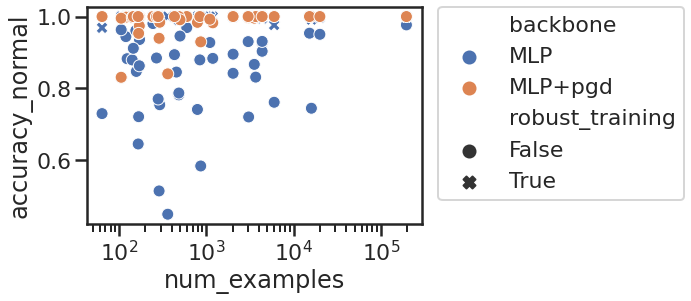

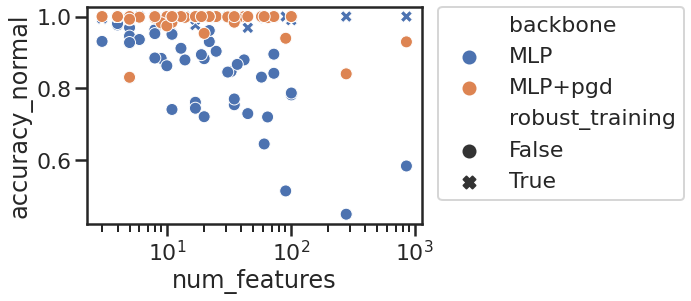

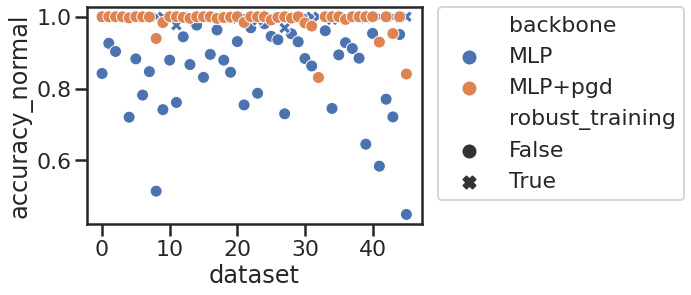

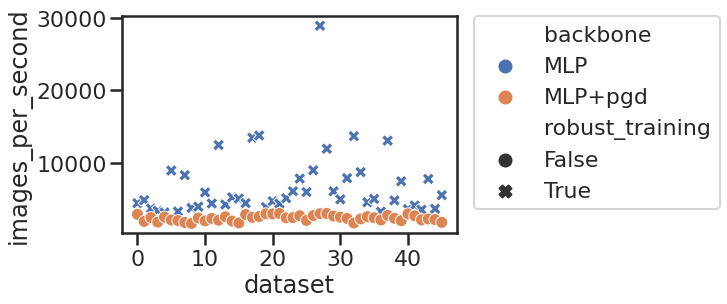

In [42]:
df_final = df_results.groupby(['backbone', 'robust_training', 'dataset']).mean().reset_index()
for idx_dd in range(0,46):
    xx = df_final[df_final.dataset == idx_dd]
    df_final.loc[df_final.dataset == idx_dd, "accuracy_normal"] = xx.accuracy / xx.accuracy.max()

        
plt.figure()
sns.scatterplot(data=df_final, x="num_examples",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="num_features",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xscale('log')

plt.figure()
sns.scatterplot(data=df_final, x="dataset",y="accuracy_normal",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.figure()
sns.scatterplot(data=df_final[~((df_final.robust_training==False)&(df_final.backbone=='MLP'))], 
                x="dataset",y="images_per_second",hue="backbone",style="robust_training")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

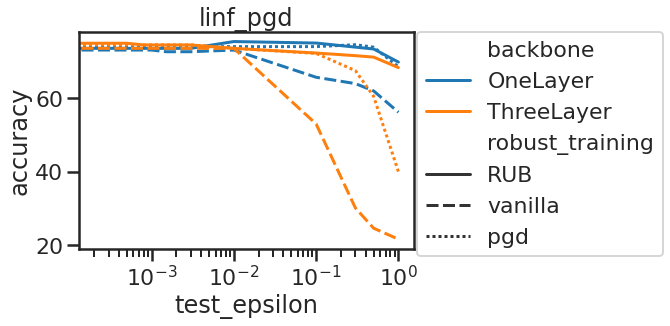

In [30]:
for dd in [61]:
    for attack in [name_attacks[0]]:
        plt.figure()
        sns.lineplot(x="test_epsilon", y="accuracy",
                     hue="backbone",  style='robust_training', palette="tab10",
                     data=df_results[(df_results.dataset==dd) & (df_results.attack==attack)]).set_title(attack)
        plt.xscale('log')
        plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

        ''' 
        plt.figure()
        epsilon = 0.1
        if attack == "l2_pgd" or attack == "l2_fgm" :
            epsilon = 1
        sns.catplot(x="backbone", y="accuracy",
                     hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                     data=df_results[(df_results.test_epsilon == 0)| (df_results.test_epsilon == epsilon)][df_results.attack==attack])
        #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
        '''
    ''' 
    plt.figure()
    sns.barplot(x="backbone", y="images_per_second",
                 hue="robust_training", palette="tab10",
                 data=df_results).set_title("time")
    plt.yscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
    '''

In [36]:
dataset = 61

# Hash table of parameters
parameters = {"epsilon": {}, "backbone": {}, "initial_learning_rate": {}, 
              "robust_training": {}, "epsilon_pgd_training":{}}

to_exclude = []
experiment_list_tmp = [element for i, element in enumerate(experiment_list) if i not in to_exclude]
for exp in experiment_list_tmp:
    if not exp["data_set"]==dataset:
        continue
        
    for kk in parameters.keys():
        if exp[kk] in parameters[kk]:
            parameters[kk][exp[kk]].append(int(exp["model_name"]))
        else:
            parameters[kk][exp[kk]] = [int(exp["model_name"])]

for kk in parameters.keys():
    print(kk)
    print(list(parameters[kk].keys()))

epsilon
[0.1, 0.0001, 1e-05, 0.001, 0.01, 0.3, 0.5, 1, 3, 5, 10]
backbone
['ThreeLayer', 'ThreeLayer+pgd', 'OneLayer', 'OneLayer+pgd']
initial_learning_rate
[1, 0.1, 0.01, 0.001, 0.0001, 1e-05, 1e-06]
robust_training
[False, True]
epsilon_pgd_training
[0.1, 0.0001, 1e-05, 0.001, 0.01, 0.3, 0.5, 1, 3, 5, 10]


In [32]:
parameters["dataset"]

KeyError: 'dataset'

In [44]:
# Display learning rate impact
epsilon = 0.01
backbone = 'ThreeLayer+pgd'
robust_training = True
epsilon_pgd_training = 0.1

if robust_training:
    ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
               set(parameters["robust_training"][robust_training]) 
               & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
else:
    ids = list(set(parameters["backbone"][backbone]) &
            set(parameters["robust_training"][robust_training]) & 
               set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))

print(ids)
list_entries = []
for id in ids:
                        
    entry = {"learning_rate": experiment_list[id]['initial_learning_rate'],
            "backbone": experiment_list[id]['backbone'],
            "robust_training": experiment_list[id]['robust_training'],
            "epsilon": experiment_list[id]['epsilon']}
 
    for dataset in ["val", "test"]:
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)
            
            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 
for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="learning_rate",  palette="tab10",
                 data=df[df.dataset=='test'][df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


[]


AttributeError: 'DataFrame' object has no attribute 'dataset'

<Figure size 432x288 with 0 Axes>

1408
1408
1408
1408
1408
1408


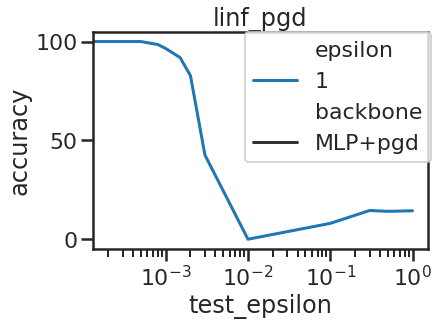

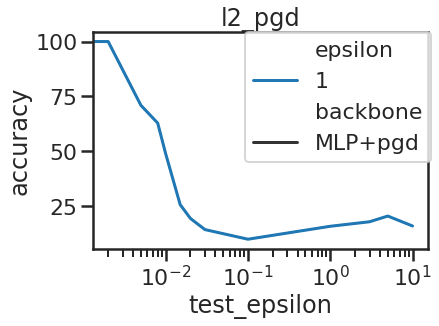

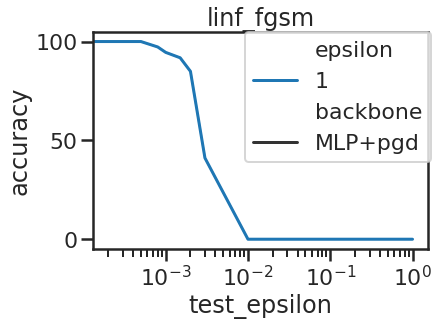

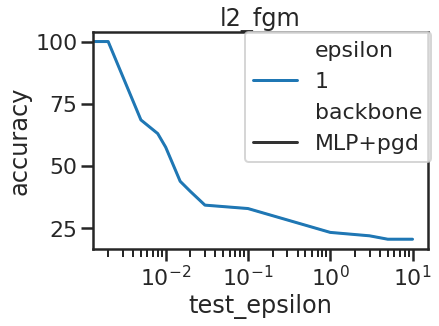

In [56]:
# Display epsilon
backbones = ['MLP+pgd']
robust_training = False
epsilon_pgd_training = 1e-3

list_entries = []
for backbone in backbones:
    for epsilon in list(parameters["epsilon"].keys()):

            
        if robust_training:
            ids = list(set(parameters["backbone"][backbone]) & set(parameters["epsilon"][epsilon]) &
                       set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
        else:
            ids = list(set(parameters["backbone"][backbone]) &
                    set(parameters["robust_training"][robust_training])
                      & set(parameters["epsilon_pgd_training"][epsilon_pgd_training]))
            
        if len(ids)==0:
            continue
            
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            acc = 0.0
            for attack in name_attacks:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[:2]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc
                
        print(best_id)
        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                
df = pd.DataFrame.from_dict(list_entries) 

for attack in name_attacks:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="epsilon",  style='backbone', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)


[1370, 1371, 1372, 1373, 1374, 1375, 1376, 1377, 1378, 1379, 1380, 1381, 1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399]
1376
[1365, 1366, 1367, 1368, 1369]
1366
[1408, 1409, 1410, 1411, 1412, 1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423, 1424, 1425, 1426, 1427, 1428, 1429, 1400, 1401, 1402, 1403, 1404, 1405, 1406, 1407]
1408


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


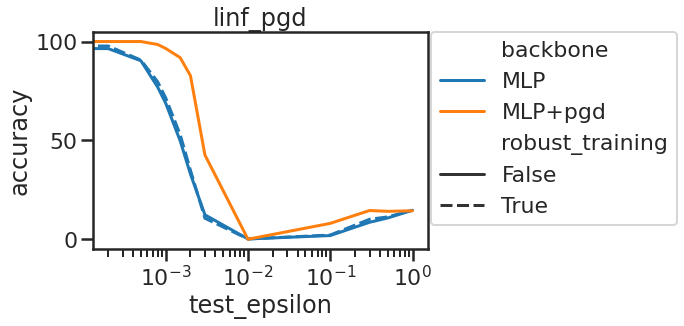

<Figure size 432x288 with 0 Axes>

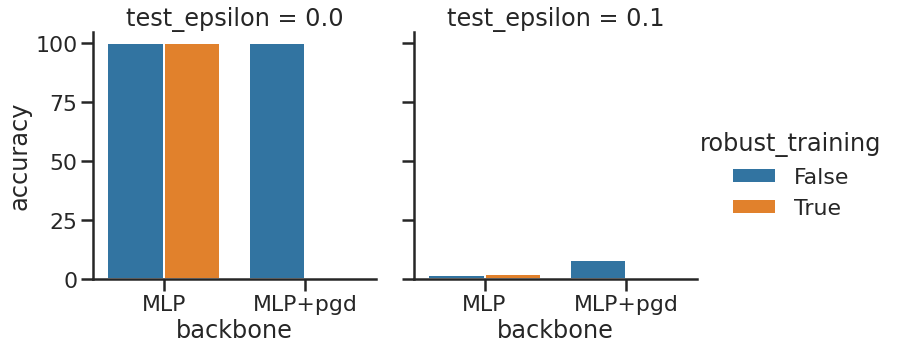

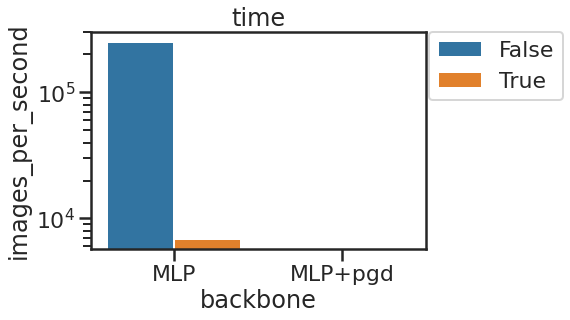

In [60]:
# Display best
backbones = ['MLP', 'MLP+pgd']
robust_trainings = [True,False]

list_entries = []
for backbone in backbones:
    for robust_training in robust_trainings:
        if (backbone == 'Madry' and robust_training == True) or \
            (backbone == 'CNN+clipping' and robust_training == False):
            continue
            
        ids = list(set(parameters["backbone"][backbone]) & set(parameters["robust_training"][robust_training]))
        
        if backbone == 'MLP+pgd' and robust_training == True:
            continue
            
        if ids == []:
            continue
        print(ids)
        
        # Cross-validation among learning rates:
        best_acc = 0.0
        best_id = -1
        for id in ids:
            #if (experiment_list[id]['backbone'] == 'CNN+pgd') and experiment_list[id]["epsilon_pgd_training"] == 0.3:
            #    continue 
            acc = 0.0
            for attack in [name_attacks[0]]:
                with open(results_dir + experiment_list[id]['model_name'] + '/results/acc_' + 'val' + '_' + 
                    attack + '.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                
                ave_acc = 0.0
                for test_epsilon in list(tmp.keys())[0:1]:
                    ave_acc += tmp[test_epsilon]
                ave_acc = ave_acc / len(tmp.keys())
                acc += ave_acc
            acc = acc / 2
            if acc>best_acc:
                best_id = id
                best_acc = acc

        entry = {"learning_rate": experiment_list[best_id]['initial_learning_rate'],
                "backbone": experiment_list[best_id]['backbone'],
                "robust_training": experiment_list[best_id]['robust_training'],
                "epsilon": experiment_list[best_id]['epsilon']}

        dataset = "test"
        print(best_id)
        for attack in name_attacks:
            entry["dataset"] = dataset
            entry["attack"] = attack
            
            if not backbone == 'Madry':
                with open(results_dir + experiment_list[best_id]['model_name'] + 
                          '/results/training_time.pkl', 'rb') as f:
                    tmp = pickle.load(f)
                entry["images_per_second"] = np.mean(tmp) 
                entry["std_images_per_second"] = np.std(tmp) 
                
            with open(results_dir + experiment_list[best_id]['model_name'] + '/results/acc_' + dataset + '_' + 
                attack + '.pkl', 'rb') as f:
                tmp = pickle.load(f)

            for test_epsilon in tmp.keys():
                entry["test_epsilon"] = test_epsilon
                entry["accuracy"] =  100*tmp[test_epsilon]
                list_entries.append(entry.copy())
                  
df = pd.DataFrame.from_dict(list_entries) 

for attack in [name_attacks[0]]:
    plt.figure()
    sns.lineplot(x="test_epsilon", y="accuracy",
                 hue="backbone",  style='robust_training', palette="tab10",
                 data=df[df.attack==attack]).set_title(attack)
    plt.xscale('log')
    plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

    plt.figure()
    epsilon = 0.1
    if attack == "l2_pgd" or attack == "l2_fgm" :
        epsilon = 1
    sns.catplot(x="backbone", y="accuracy",
                 hue="robust_training", col="test_epsilon", palette="tab10",kind="bar",
                 data=df[(df.test_epsilon == 0)| (df.test_epsilon == epsilon)][df.attack==attack])
    #plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

plt.figure()
sns.barplot(x="backbone", y="images_per_second",
             hue="robust_training", palette="tab10",
             data=df).set_title("time")
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)

In [ ]:
df[(df.test_epsilon==0.01)&(df.attack=='linf_pgd')]

In [87]:
df[df.backbone=="Madry"][df.attack=="linf_pgd"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
218,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN
270,0.001,Madry,True,0.1,test,linf_pgd,0.3,93.515625,NaN,NaN


In [107]:
df[df.backbone=="Madry"][df.attack=="linf_fgsm"][df.test_epsilon == 0.3 ]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,learning_rate,backbone,robust_training,epsilon,dataset,attack,test_epsilon,accuracy,images_per_second,std_images_per_second
244,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
296,0.001,Madry,True,0.1,test,linf_fgsm,0.3,95.507812,NaN,NaN
